# DEJMPS Protocol

In [1]:
#imports
from qutip import *
from qutip_qip.circuit import QubitCircuit
from qutip_qip.operations import Gate, cnot
import numpy as np
from math import pi
import matplotlib.pyplot as plt
from qutip.qip.operations.gates import (rx, ry, rz)
import random
from qutip.measurement import measure



In [2]:
#FUNCTION TO CHECK IF A STATE IS A WERNER STATE

def check_werner_r1(rho, tol=1e-6):
    """
    Check whether a 4x4 matrix rho corresponds to the Werner-type state:
    rho_W = r1 * |1><1| + (1-r1)/3 * (I4 - |1><1|)
    where |1> = (|01> - |10>)/sqrt(2).
    In the computational basis {|00>, |01>, |10>, |11>}, the matrix form is:
    rho_W = [[(1-r1)/3, 0, 0, 0],
    [0, (2*r1+1)/6, (1-4*r1)/6, 0],
    [0, (1-4*r1)/6, (2*r1+1)/6, 0],
    [0, 0, 0, (1-r1)/3]]
    Parameters
    ----------
    rho : 2D numpy array (shape (4,4))
    The density matrix to test.
    tol : float
    Numerical tolerance for consistency checks.
    Returns
    -------
    (is_werner, r1_value)
    is_werner : bool
    True if all derived r1 values match within 'tol'.
    r1_value : float or None
    The average r1 if consistent, else None.
    """

    # Corner diagonals (should be (1-r1)/3):

    corner_val = rho[0, 0] # same as rho[3,3] ideally

    # Center diagonals (should be (2*r1 + 1)/6):

    center_diag_val = rho[1, 1] # same as rho[2,2] ideally

    # Off-diagonals in the center block (should be (1 - 4*r1)/6):

    center_offdiag_val = rho[1, 2] # same as rho[2,1] ideally

    # Solve for r1 from each expression:

    # 1) corner_val = (1 - r1)/3 => r1 = 1 - 3 * corner_val

    r1_corner = 1.0 - 3.0 * corner_val

    # 2) center_diag_val = (2*r1 + 1)/6 => 2*r1 + 1 = 6*center_diag_val => r1 = 3*center_diag_val - 0.5

    r1_center_diag = 3.0 * center_diag_val - 0.5

    # 3) center_offdiag_val = (1 - 4*r1)/6 => 1 - 4*r1 = 6*center_offdiag_val => r1 = (1 - 6*center_offdiag_val)/4

    r1_center_offdiag = (1.0 - 6.0 * center_offdiag_val) / 4.0

    # Put them all in a list

    r1_candidates = [r1_corner, r1_center_diag, r1_center_offdiag]

    # Check if they are all close within 'tol'
    if (np.allclose(r1_corner, r1_center_diag, atol=tol) and np.allclose(r1_corner, r1_center_offdiag, atol=tol)):

        # If consistent, return average

        r1_mean = np.mean(r1_candidates)
        return True, r1_mean
    else:
    # Not consistent -> not a Werner state of this specific form
        return False, None



In [3]:
# phi_plus = bell_state("00")
# phi_minus = bell_state("01")
# psi_plus = bell_state("10")
# psi_minus = bell_state("11")

# def bds_state(F):
#     p1 = F
#     p2 = (1-p1)/2
#     p3 = (1-p1)/3
#     p4 = (1-p1)/6

#     state = p1 * (phi_plus * phi_plus.dag()) + p2 * (psi_plus * psi_plus.dag()) + p3 * phi_minus * phi_minus.dag() + p4 * psi_minus * psi_minus.dag()
#     return state

# bds_state = bds_state(0.7)
# print(bds_state)
# print(fidelity(bds_state, bell_state("00")))

In [4]:
# purification_circuit = QubitCircuit(N = 4)
# purification_circuit.add_gate("RX", targets = [0], arg_value= pi/2, style={"showarg": True})
# purification_circuit.add_gate("RX", targets = [1], arg_value= -pi/2, style={"showarg": True})
# purification_circuit.add_gate("RX", targets = [2], arg_value= pi/2, style={"showarg": True})
# purification_circuit.add_gate("RX", targets = [3], arg_value= -pi/2, style={"showarg": True})
# purification_circuit.add_gate("CNOT", targets = [2], controls=[0])
# purification_circuit.add_gate("CNOT", targets = [3], controls=[1])

# purification_result = purification_circuit.run(state = tensor(bds_state, bds_state))
# # print(purification_result)
# Z0, Z1 = ket2dm(basis(2, 0)), ket2dm(basis(2, 1))
# PZ1 = [tensor(identity(2), identity(2), Z0, Z0), tensor(identity(2), identity(2), Z1, Z1), tensor(identity(2), identity(2), Z0, Z1), tensor(identity(2), identity(2), Z1, Z0)]
# measurement_result = measure(purification_result,PZ1)
# # print(measurement_result[1])

# if measurement_result[0] == 0 or measurement_result[0] == 1:
#     print("succesful purification result")
#     # post_purification_state = purification_result.ptrace([0,1])
#     print(purification_result.ptrace([0,1]))
#     print(fidelity(purification_result.ptrace([0,1]),bell_state("00")))


# purification_circuit.draw("matplotlib", dpi=200)

In [5]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
from math import pi
from qutip.qip.operations.gates import (rx, ry, rz)
from qutip.measurement import measure_povm

In [6]:
phi_plus = bell_state("00")
phi_minus = bell_state("01")
psi_plus = bell_state("10")
psi_minus = bell_state("11")

def bds_state(F):
    p1 = F
    p2 = (1-p1)/2
    p3 = (1-p1)/3
    p4 = (1-p1)/6

    state = p1 * (phi_plus * phi_plus.dag()) + p2 * (psi_plus * psi_plus.dag()) + p3 * phi_minus * phi_minus.dag() + p4 * psi_minus * psi_minus.dag()
    return state


In [7]:
def rx_rotation(state):
    rx_rotation_0 = tensor(rx(pi/2), qeye(2), qeye(2), qeye(2))
    rx_rotation_1 = tensor(qeye(2), rx(-pi/2), qeye(2), qeye(2))
    rx_rotation_2 = tensor(qeye(2), qeye(2), rx(pi/2), qeye(2))
    rx_rotation_3 = tensor(qeye(2), qeye(2), qeye(2), rx(-pi/2))

    state = rx_rotation_0 * state * rx_rotation_0.dag()
    state = rx_rotation_1 * state * rx_rotation_1.dag()
    state = rx_rotation_2 * state * rx_rotation_2.dag()
    state = rx_rotation_3 * state * rx_rotation_3.dag()
    return state


def unilateral_y_rotation(state):
    #create custom unilateral y-rotation operators
    u_rotation_qubit0 = tensor(sigmay(), qeye(2), qeye(2), qeye(2))
    u_rotation_qubit2 = tensor(qeye(2), qeye(2), sigmay(), qeye(2))

    #apply unilateral y-rotation on qubit 0 and 2 
    state = u_rotation_qubit0 * state * u_rotation_qubit0.dag()
    state = u_rotation_qubit2 * state * u_rotation_qubit2.dag()
    return state

def bilateral_xor(rho):
    #define zero and one basis for our 4-qubit system
    zero_state = basis(2,0) * basis(2,0).dag()
    one_state = basis(2,1) * basis(2,1).dag()

    # generate bxor operators for different operators
    bxor02 = tensor(zero_state, qeye(2), qeye(2), qeye(2)) + tensor(one_state, qeye(2), sigmax(), qeye(2))
    bxor13 = tensor(qeye(2), zero_state, qeye(2), qeye(2)) + tensor(qeye(2), one_state, qeye(2), sigmax())

    #generate bxor operators for different operators
    # bxor02 = tensor(zero_state, qeye(2), qeye(2), qeye(2)) + tensor(one_state, qeye(2), sigmax(), qeye(2))
    # bxor13 = tensor(qeye(2), zero_state, qeye(2), qeye(2)) + tensor(qeye(2), one_state, sigmax(), qeye(2))

    rho = bxor02 * rho * bxor02.dag()
    rho = bxor13 * rho * bxor13.dag()
    return rho

def measure_qubits(state):
    Z0 = ket2dm(basis(2, 0))
    Z1 = ket2dm(basis(2, 1))
    # The measurement POVM elements act as identity on qubits 0 and 1:
    PZ = [
        tensor(qeye(2), qeye(2), Z0, Z0),
        tensor(qeye(2), qeye(2), Z1, Z1),
        tensor(qeye(2), qeye(2), Z0, Z1),
        tensor(qeye(2), qeye(2), Z1, Z0)
    ]
    
    outcome, final = measure_povm(state, PZ)
    return outcome, final

In [8]:
def dejmps(input_fidelity):
    # print("Final Fidelity:", input_fidelity)
    bds_input = bds_state(input_fidelity)
    rho = tensor(bds_input,bds_input)
    
    #START PURIFICATION PROCESS``
    #apply x-rotations on each qubit alternating b/w pi/2 and (-pi/2)
    rho = rx_rotation(rho)

    #apply bilateral xor on qubits (0,2) and (1,3)
    rho = bilateral_xor(rho)

    #measure target qubits 2 and 3, keep 
    measurement_result, rho_post =  measure_qubits(rho)
    
    #check for successful purification
    if measurement_result in [0,1]:
        purified_state = rho_post.ptrace([0,1])

        y_rotation = tensor(sigmay(), qeye(2))
        purified_state = y_rotation * purified_state * y_rotation.dag()

        output_fidelity = fidelity(purified_state, bell_state("11"))
        output_fidelity_squared = output_fidelity * output_fidelity
        # print("Final Fidelity:", output_fidelity_squared)
        return purified_state, output_fidelity_squared
    # else:
    #     # print("Purification Failed")
    return None, None

dejmps(0.7)

(Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
 Qobj data =
 [[ 5.00000000e-02  0.00000000e+00  4.36057081e-35 -2.00000000e-03]
  [-4.74876939e-34  4.50000000e-01 -3.38000000e-01  7.40243620e-35]
  [ 7.40243620e-35 -3.38000000e-01  4.50000000e-01 -4.74876939e-34]
  [-2.00000000e-03  0.00000000e+00 -2.58403521e-35  5.00000000e-02]],
 0.7880000000000004)

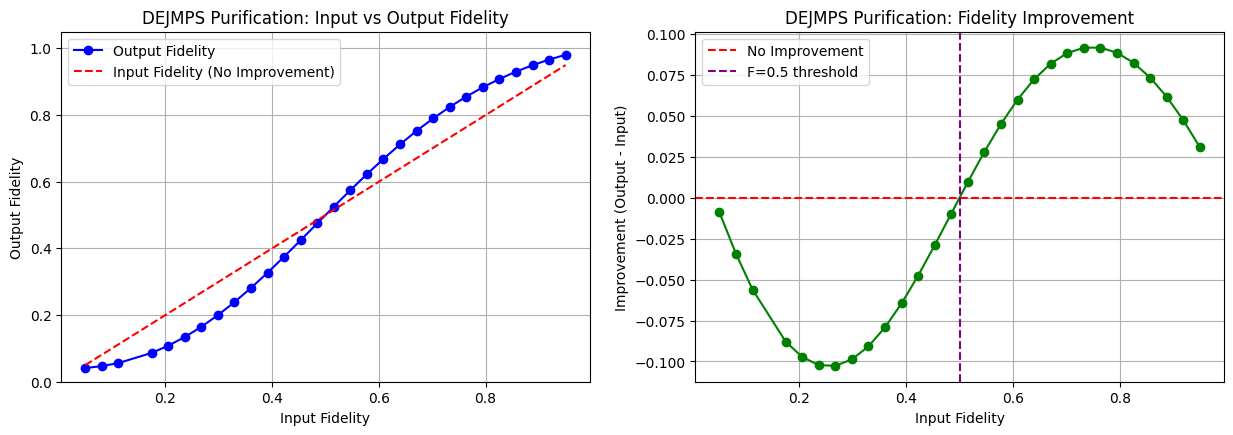

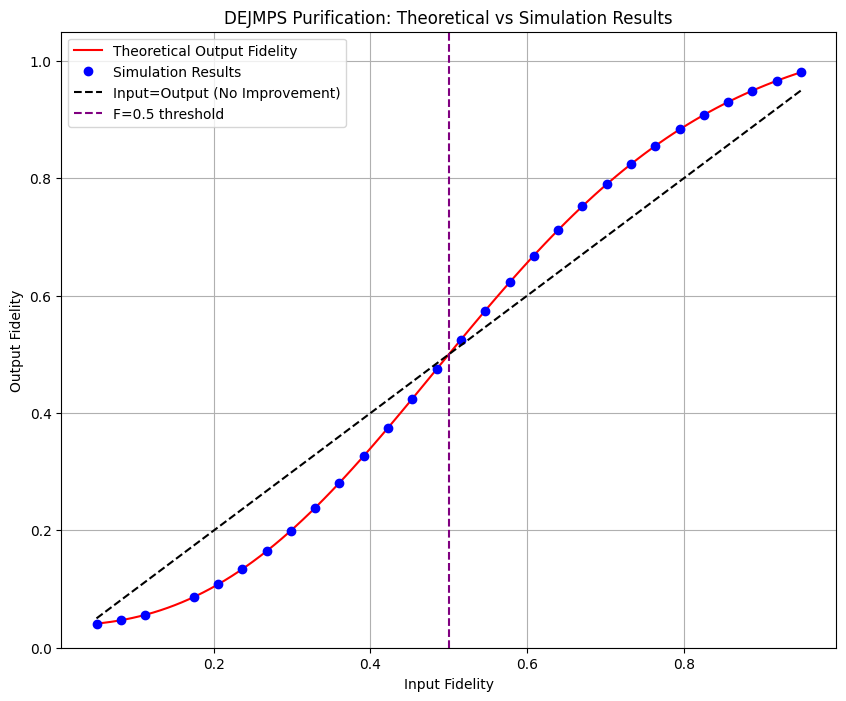

Summary of DEJMPS Purification Results:
----------------------------------------
F=0.5 is the theoretical threshold for purification to work
Input F: 0.050, Output F: 0.041, No improvement: -0.009, Success Prob: 0.134
Input F: 0.081, Output F: 0.047, No improvement: -0.034, Success Prob: 0.150
Input F: 0.112, Output F: 0.056, No improvement: -0.056, Success Prob: 0.167
Input F: 0.174, Output F: 0.086, No improvement: -0.088, Success Prob: 0.202
Input F: 0.205, Output F: 0.108, No improvement: -0.097, Success Prob: 0.221
Input F: 0.236, Output F: 0.134, No improvement: -0.102, Success Prob: 0.241
Input F: 0.267, Output F: 0.165, No improvement: -0.103, Success Prob: 0.262
Input F: 0.298, Output F: 0.200, No improvement: -0.099, Success Prob: 0.283
Input F: 0.329, Output F: 0.239, No improvement: -0.091, Success Prob: 0.306
Input F: 0.360, Output F: 0.281, No improvement: -0.079, Success Prob: 0.329
Input F: 0.391, Output F: 0.327, No improvement: -0.065, Success Prob: 0.353
Input F: 0.4

In [9]:
def calculate_success_probability(input_fidelity):
    """Calculate the theoretical success probability for DEJMPS purification."""
    F = input_fidelity
    return F**2 + (1-F)**2/9 + 2*F*(1-F)/3

# Generate data for the plot - start from 0.05 instead of 0.5
input_fidelities = np.linspace(0.05, 0.95, 30)
output_fidelities = []
improvements = []
success_probabilities = []

# For each input fidelity, perform the purification and record results
for F_in in input_fidelities:
    _, F_out = dejmps(F_in)
    
    # If purification was successful, record the improvement
    if F_out is not None:
        output_fidelities.append(F_out)
        improvements.append(F_out - F_in)
        success_prob = calculate_success_probability(F_in)
        success_probabilities.append(success_prob)
    else:
        # Retry a few times in case we got unlucky with the measurement outcomes
        for _ in range(5):
            _, F_out = dejmps(F_in)
            if F_out is not None:
                output_fidelities.append(F_out)
                improvements.append(F_out - F_in)
                success_prob = calculate_success_probability(F_in)
                success_probabilities.append(success_prob)
                break
        else:
            # If all retries failed, append None
            output_fidelities.append(None)
            improvements.append(None)
            success_probabilities.append(None)

# Remove any None entries from the data
valid_indices = [i for i, val in enumerate(output_fidelities) if val is not None]
valid_inputs = [input_fidelities[i] for i in valid_indices]
valid_outputs = [output_fidelities[i] for i in valid_indices]
valid_improvements = [improvements[i] for i in valid_indices]
valid_success_probs = [success_probabilities[i] for i in valid_indices]

# Create the plots
plt.figure(figsize=(15, 10))

# Plot 1: Input vs Output Fidelity
plt.subplot(2, 2, 1)
plt.plot(valid_inputs, valid_outputs, 'bo-', label='Output Fidelity')
plt.plot(valid_inputs, valid_inputs, 'r--', label='Input Fidelity (No Improvement)')
plt.xlabel('Input Fidelity')
plt.ylabel('Output Fidelity')
plt.title('DEJMPS Purification: Input vs Output Fidelity')
plt.legend()
plt.grid(True)
plt.ylim(0, 1.05)  # Set y-axis limits for fidelity

# Plot 2: Input Fidelity vs Improvement
plt.subplot(2, 2, 2)
plt.plot(valid_inputs, valid_improvements, 'go-')
plt.xlabel('Input Fidelity')
plt.ylabel('Improvement (Output - Input)')
plt.title('DEJMPS Purification: Fidelity Improvement')
plt.axhline(y=0, color='r', linestyle='--', label='No Improvement')
plt.legend()
plt.grid(True)
plt.axvline(x=0.5, color='purple', linestyle='--', label='F=0.5 threshold')
plt.legend()

plt.savefig('plots//dejmps/dejmps_purification_plots_extended.png', dpi=300)
plt.show()

# Add additional theoretical curve for comparison
F_theory = np.linspace(0.05, 0.95, 100)

def dejmps_theoretical_output(F):
    # Calculate the numerator and denominator separately
    p1 = F
    p2 = (1-p1)/2
    p3 = (1-p1)/3
    p4 = (1-p1)/6

    numerator = p1**2 + p4**2
    denominator = (p1+p4)**2 + (p2+p3)**2
    
    # Calculate F'
    F_prime = numerator / denominator
    
    return F_prime

# Plot theoretical vs experimental curves
plt.figure(figsize=(10, 8))
theory_outputs = [dejmps_theoretical_output(f) for f in F_theory]
plt.plot(F_theory, theory_outputs, 'r-', label='Theoretical Output Fidelity')
plt.plot(valid_inputs, valid_outputs, 'bo', label='Simulation Results')
plt.plot(F_theory, F_theory, 'k--', label='Input=Output (No Improvement)')
plt.axvline(x=0.5, color='purple', linestyle='--', label='F=0.5 threshold')
plt.xlabel('Input Fidelity')
plt.ylabel('Output Fidelity')
plt.title('DEJMPS Purification: Theoretical vs Simulation Results')
plt.legend()
plt.grid(True)
plt.ylim(0, 1.05)
plt.savefig('plots/dejmps/dejmps_theoretical_v_simulation.png', dpi=300)
plt.show()

# Print a summary of results
print("Summary of DEJMPS Purification Results:")
print("----------------------------------------")
print("F=0.5 is the theoretical threshold for purification to work")
for i, f_in in enumerate(valid_inputs):
    imp_status = "Improvement" if valid_improvements[i] > 0 else "No improvement"
    print(f"Input F: {f_in:.3f}, Output F: {valid_outputs[i]:.3f}, "
          f"{imp_status}: {valid_improvements[i]:.3f}, Success Prob: {valid_success_probs[i]:.3f}")